# Centrale Krachten

## De effectieve potentiaal

We werken symbolisch via SymPy. De Yukawa-potentiaal en de angulaire kinetische
energie wordt gedefinieerd.

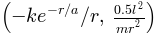

In [1]:
from sympy import symbols, exp, nsolve, init_printing, sqrt, Derivative, Eq, plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, animation

pltm=7  # plot scaling, for addapting the plotting to your screen size
plt.rc('figure', figsize=(pltm, pltm))
plt.rc('font', size=pltm * 3)
rc('animation', html='html5')
init_printing()  # voor pretty printing of sympy vergelijkingen

r, a, k, m, l, E  = symbols('r,a,k,m,l,E', real=True)
Yukawa = -k / r * exp(-r / a) 

# Angulaire kinetische energie
T_angulair = 1/2 * l ** 2 / (m * r ** 2)

# De effectieve potentiaal
Veff = T_angulair + Yukawa

Yukawa, T_angulair

De cirkelvoorwaarde wordt gegeven door de extremale punten van de effectieve 
potentiaal (nulpunten van de afgeleide):

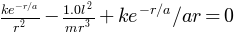

In [2]:
f_cirkel = Eq(Derivative(Veff, r).doit(), 0)
f_cirkel

Dit is dezelfde voorwaarde als afgeleid in oefeningenreeks 5. 
We kiezen de systeemvariabelen $(a, m, k)$ gelijk aan 1 en kiezen het 
impulsmoment zodanig dat er een cirkelbaan is op $r = 3$. De positieve
oplossing van het impulsmoment kan gekozen worden zonder verlies van
algemeenheid.

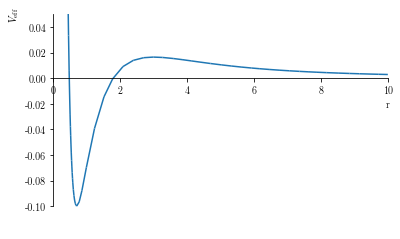

In [3]:
# variabelen: m = 1, a = 1, k = 1
var = {m: 1., a: 1., k: 1.}

# Invullen van variabelen in voorwaarde cirkelbaan
f_cirkel = f_cirkel.subs(var)
# Oplossen naar l voor r_cirkel=3
var[l] = abs(nsolve(f_cirkel.subs(r, 3), l, 1))

plot(Veff.subs(var), xlim=(0, 10), ylim=(-0.12, 0.05), xlabel='r', ylabel=r'$V_\mathrm{eff}$')

Grafisch zien we dat het extremum bij $r = 3$ een onstabiele cirkelbaan zal 
opleveren **(maximum)** terwijl er ook een tweede cirkelbaan aanwezig is die 
stabiel is **(minimum)**.

In [4]:
r_onstabiel = nsolve(f_cirkel.subs(var), r, 2.5)
r_stabiel = nsolve(f_cirkel.subs(var), r, 0.5)
r_onstabiel, r_stabiel

## Berekenen van de baan

De centrale krachtproblemen die we vinden in de lessen worden getypeerd door
bewegingsvergelijkingen van de volgende vorm:
 
\begin{align}
    m\ddot{r} &= -\frac{\partial V_\mathrm{eff}}{\partial r}\\
    l &= m r^2 \dot{\phi}
\end{align}

In plaats om de eerste bewegingsvergelijking voor $r$ te gebruiken, is het 
eenvoudiger om met behoud van energie te werken:

\begin{align}
    E &= T + V\\
    E &= \frac{1}{2} m \left(\dot{r}^2 + r^2\dot{\phi}^2\right) + V(r)\\
    E &= \frac{1}{2} m \dot{r}^2 + \frac{1}{2} \frac{l^2}{mr^2} + V(r)\\
\end{align}

In dit geval bekomen we dus de volgende twee differentiaalvergelijkingen:

\begin{align}
    \dot{\phi} &= \frac{l}{mr^2}\\
    \dot{r} &= \pm \sqrt{\frac{2}{m}\left(E - \frac{1}{2} \frac{l^2}{mr^2} - V(r)\right)}
    = \pm \sqrt{\frac{2}{m}\left(E - V_\mathrm{eff}(r)\right)}
\end{align}

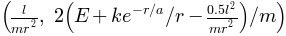

In [5]:
phidot = l / (m * r ** 2)
rdot_sq = 2 / m * (E - Veff)
phidot, rdot_sq

### De Euler-methode

Indien een initiële $r$ en $\phi$ is gekozen, kunnen deze
differentiaalvergelijkingen gebruikt worden om het systeem te evolueren in de
tijd. We gebruiken hier de
[Euler-methode](https://nl.wikipedia.org/wiki/Methode_van_Euler), dit is de
simpelste methode om gewone differentiaalvergelijkingen numeriek op te lossen.
Accuratere methoden bestaan (zoals bijvoorbeeld
[Runge-Kutta](https://nl.wikipedia.org/wiki/Runge-Kuttamethode)), maar voor
deze simpele problemen volstaat de Euler-methode. De Euler-methode is gegeven
door:

\begin{equation}
    x(t + Δt) \approx x(t) + \dot{x}(t)Δt
\end{equation}

Hoe kleiner $Δt$ gekozen, hoe accurater de verkregen baan.

In [6]:
def Euler(rdot_sq, phidot, r_start, r_teken=1., phi_start=0, t_tot=175., dt=0.02):
    # Zeker zijn dat de effectieve potentiaal op de beginpositie kleiner is 
    # dan de totale energie van het systeem.
    rdsq = rdot_sq(r_start)
    assert rdsq >= 0

    steps = int(t_tot / dt)
    r = np.zeros(steps)
    phi = np.zeros(steps)
    t = np.linspace(0, t_tot, num=steps, endpoint=False)


    r[0] = r_start
    phi[0] = phi_start
    rnext = r_teken * dt * np.sqrt(rdot_sq(r[0]))
    for step in range(len(t) - 1):
        # Euler-update: bereken de volgende waarde voor r        
        r[step + 1] = r[step] + r_teken * dt * np.sqrt(rdsq)
        rdsq = rdot_sq(r[step + 1])
        
        if rdsq < 0:
            r[step + 1] = r[step]
            rdsq = rdot_sq(r[step + 1])
            r_teken *= -1
        # Euler-update: bereken de volgende waarde voor phi
        phi[step + 1] = phi[step] + dt * phidot(r[step])
    return t, r, phi

$r$ en $\phi$ worden respectievelijk op `r_start` en `phi_start` 
geïnitialiseerd. Het initieel teken van $\dot{r}$ kan ook gespecificeerd worden 
(via `r_teken`) aangezien deze niet bepaald wordt door de 
bewegingsvergelijkingen.

Het updaten van $\phi(t)$ gebeurt door een simpele Euler-update. Bij het 
updaten van $r(t)$ moet er nog rekening gehouden worden dat het argument 
onder wortel in

\begin{align}
    \dot{r} &= \pm \sqrt{\frac{2}{m}\left(E - - V_\mathrm{eff}(r)\right)}
\end{align}

negatief kan worden na een update doordat $V_\mathrm{eff} > E$.
 
Deze situatie is fysisch niet mogelijk, we zullen nooit door de
potentiaal-barrière breken. Op de barrière zal $\dot{r} = 0$ worden en daarna
veranderen van teken. Dat er hier door de potentiaal-barrière gebroken wordt is
slechts een artifact door de eindige tijdsstappen.

We moeten hiervoor dus corrigeren. We corrigeren door:

```python
if Veff(r[step + 1]) > E:
    r[step + 1] = r[step]
    r_teken *= -1
```

Indien we de potentiaal-barrière zouden doorbreken, zetten we het deeltje terug
op zijn vorige positie $r$ en veranderen we het teken van $\dot{r}$. Dit is
slechts een ruwe correctie, maar accuraat genoeg indien kleine tijdsstappen
genomen worden.
 

## Stabiele Cirkelbaan

We bestuderen eerst de stabiele cirkelbaan. De stabiele cirkelbaan wordt
bevindt zicht op ($\dot{r} = 0 → V_\mathrm{eff} = E$):

In [7]:
E_stabiel = Veff.subs(var).subs(r, r_stabiel).evalf()
print(f'r={r_stabiel}, E={E_stabiel}')

r=0.710910702782015, E=-0.0998716832836403


We illustreren de stabiliteit van deze cirkelbaan door de
bewegingsvergelijkingen expliciet op te lossen met de Euler-methode voor een
energie licht afwijkend van $E_\mathrm{stabiel}$.

In [8]:
def polar_plot(r_init, rlim=None, animate=True, **kwargs):
    '''Functie voor het plotten van de baan.

    Args:
        r_init: Initiele afstand r van de oorsprong
        rlim: Indien niet None, wordt het logarithmisch verschil van r met rlim
        in de rechterplot weergegeven.
        anim: Indien True wordt een animatie van de baan geplot.

    kwargs:
        keyword arguments voor `Euler`.
    '''
    from IPython.display import HTML
    
    rdsq = rdot_sq.subs(var)
    phd = phidot.subs(var)
    t_a, r_a, phi_a = Euler(
        lambda x: float(rdsq.subs(r, x).evalf()),
        lambda x: float(phd.subs(r, x).evalf()),
        r_init, **kwargs
    )

    plt.rc('figure', figsize=(pltm * 2, pltm))
    plt.rc('font', size=pltm * 3)
    plt.rc('lines', lw=1)
    
    fig = plt.figure()
    ax1 = plt.subplot(121, projection = 'polar')
    ax1.set_ylim(0, max(r_a) + 0.3)
    ax1.set_xticks([])

    ax2 = plt.subplot(122)
    ax2.set_xlabel(r"time $t$")
    ax2.set_ylabel(r"$r$")
    ax2.set_xlim(0, max(t_a))

    if animate:
        ims = []
        for frame in range(0, len(t_a), len(t_a) // 50):
            im1 = ax1.plot(phi_a[:frame], r_a[:frame], 'b', phi_a[frame], r_a[frame], 'bo', ms=10)
            if rlim is None:
                im2 = ax2.plot(t_a[:frame], r_a[:frame], 'b', t_a[frame], r_a[frame], 'bo', ms=10)
            else:
                im2 = ax2.semilogy(t_a[:frame], abs(r_a[:frame] - rlim), 'b',
                                   t_a[frame], abs(r_a[frame] - rlim), 'bo', ms=10)
            ims.append([*im1, *im2])
            plt.close()
        return animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=500, blit=True)
    else:
        ax1.plot(phi_a, r_a, 'b',)
        if rlim is None:
            ax2.plot(t_a, r_a, 'b')
        else:
            ax2.semilogy(t_a, abs(r_a - rlim), 'b')

In [9]:
var[E] = E_stabiel + 1e-5
polar_plot(r_stabiel, t_tot=20)

Deze baan is duidelijk stabiel ten opzichte van kleine afwijkingen.

## Onstabiele cirkelbaan

Nu bestuderen we de onstabiele cirkelbaan:

In [10]:
E_onstabiel = Veff.subs(var).subs(r, r_onstabiel).evalf()
print(f'r={r_onstabiel:.2f}, E={E_onstabiel}')

r=3.00, E=0.0165956894559546


We bestuderen initieel wat er gebeurt indien $E = E_\mathrm{onstabiel}$.

In tegenstelling tot de stabiele cirkelbaan kunnen we de onstabiele cirkelbaan
op posities met $r ≠ r_\mathrm{cirkel}$ starten. We beschouwen

* $E = E_\mathrm{onstabiel}$ en $r_\mathrm{init} > r_\mathrm{onstabiel}$

In [11]:
var[E] = E_onstabiel
polar_plot(r_onstabiel * 3, rlim=r_onstabiel, r_teken=-1)

* $E = E_\mathrm{onstabiel}$ en $r_\mathrm{init} < r_\mathrm{onstabiel}$

In [12]:
polar_plot(r_onstabiel * .5, rlim=r_onstabiel, r_teken=-1, t_tot=100)

We merken dat ongeacht de beginpositie het deeltje exponentieel snel naar de
onstabiele cirkelbaan nadert. In tegenstelling tot wat de naam *onstabiel* laat
vermoeden is de cirkelbaan dus eigenlijk heel stabiel indien de energie
**exact** gelijk is aan $E_\mathrm{onstabiel}$.

Wanneer we de energie echter doen verschillen van $E_\mathrm{onstabiel}$, wordt
het ons echter duidelijk waarom de cirkelbaan onstabiel wordt genoemd.

* $E > E_\mathrm{onstabiel}$ en $r = r_\mathrm{onstabiel}$

In [13]:
var[E] = E_onstabiel + 1e-5
polar_plot(r_onstabiel, r_teken=-1)

* $E < E_\mathrm{onstabiel}$ en $r < r_\mathrm{onstabiel}$

In [14]:
var[E] = E_onstabiel - 1e-5
polar_plot(r_onstabiel * .5, r_teken=-1)

* $E < E_\mathrm{onstabiel}$ en $r > r_\mathrm{onstabiel}$

In [ ]:
polar_plot(r_onstabiel * 3, r_teken=-1)